In [81]:
# 환경 setting
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 588 (delta 5), reused 3 (delta 1), pack-reused 569
Receiving objects: 100% (588/588), 57.41 MiB | 27.46 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/nlp-with-transformers/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.27.3
Using datasets v2.10.1
Using accelerate v0.18.0
Using sentencepiece v0.1.97
Using umap v0.5.3


# 데이터셋

In [82]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 25955개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


In [83]:
from datasets import load_dataset

# data set마다 이름이 있음
# emotion data set loading 하기
emotions = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [84]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [85]:
# emotion 객체에서 key를 통해 개별 분할 set 참조 가능
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [86]:
len(train_ds)

16000

In [87]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [88]:
# data set의 attribute이 dictionary로 표현됨
# key가 column name에 해당
train_ds.column_names

['text', 'label']

In [89]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [90]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


In [91]:
# Data set 객체를 판다스 DataFrame으로 변환하여 사용하기
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [92]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

# 새로운 key 생성
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


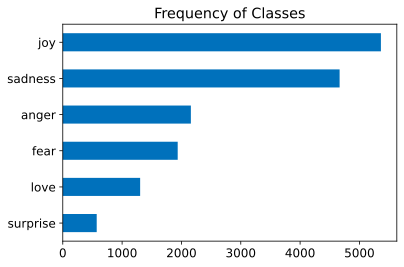

In [93]:
# class distribution
import matplotlib.pyplot as plt

# bar() 함수는 막대 그래프를 그리는 함수
# barh() 함수를 통해 막대 그래프를 수평으로 그림
#df["label_name"].value_counts(ascending=True).plot.bar()
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

위의 막대그래프를 통해 data set의 불균형이 심함을 알 수 있음.
joy와 sadness class 비중은 크고, love, surprise는 굉장히 작음

### Imbalanced data를 다루는 방법<br>
- 소수 클래스를 랜덤하게 Oversampling
- 다수 클래스를 랜덤하게 Undersampling
- labeled data를 더 수집

> train/test set 분할을 하기 전에는 sampling 전략을 적용하면 안됨 <br>
정보 손실이 있을 수 있음<br>
일반적으로는 train set에만 sampling 전략을 사용

In [94]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


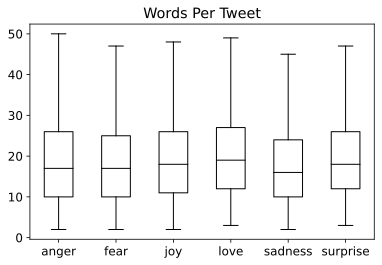

In [95]:
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [96]:
# 더 이상 DataFrame의 format이 필요하지 않으니 출력 format 초기화
emotions.reset_format()

# 텍스트에서 토큰으로

## 문자 토큰화

In [97]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [98]:
# 수치화 (numericalization)
# enumerate: index, element를 동시에 반환 받을 수 있음
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [99]:
# dictionary를 기반으로 문자 token을 정수 token으로 mapping
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [100]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [101]:
# 판다스에서는 get_dummies 함수를 통해 one-hot vector를 만듦
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


### One-Hot vector
- 위의 input_ids의 경우 원소 사이에 순서가 생기는 문제가 발생할 수 있음.
(신경망은 이런 종류의 관계를 학습하는 능력이 매우 뛰어나다고 함.) <br>
- 두 ID를 더하거나 빼면 연산의 결과가 다른 token을 나타냄 → 무의미
- one-hot vector의 경우 순서 문제도 없을 뿐더러 덧셈 연산이 token이 동시에 등장한다는 의미를 가질 수 있음


In [102]:
# pytorch로 원-핫 인코딩 만들기
import torch
import torch.nn.functional as F

print(input_ids)
input_ids = torch.tensor(input_ids)
print(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]
tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])


torch.Size([38, 20])

38개의 입력 token 각각에 20 차원의 one-hot vector가 만들어짐 (= class 종류가 20개)

In [103]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


- 문자 토큰화 방식은 철자 오류나 희귀한 단어를 처리하는데 유용
- 단어 같은 언어 구조를 학습하기 어려워 실제로 잘 사용되지 않음

## 단어 토큰화

In [104]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


단어의 활용형, 철자 오류 등이 포함되면 어휘 사전이 방대해짐 <br>
→ 신경망의 parameter가 많이 필요해짐<br>
ex) 100만 개의 고유 단어를 first layer에서 1000 차원의 vector로 압축하는 경우 100만 * 1000 = 10억 개의 weight이 필요<br>
<br>
어휘 사전의 크기를 제한하기 위해 **단어를 무시**하는 방법을 사용할 수 있음<br>
- corpus에서 자주 등장하는 10만 개의 단어만을 사용<br>
- 어휘 사전에 없는 단어는 UNK(unknown) token으로 mapping<br>
- 단어 토큰화 과정에서 **중요한 정보를 일부 손실**

모든 입력 정보와 일부 입력 구조를 유지하는 문자 토큰화와 단어 토큰화를 절충 <br>
→ **부분단어 토큰화**

## 부분단어 토큰화
드물게 등장하는 단어 → 더 작은 단위로 나눈다 <br>
복잡한 단어나 철자 오류를 처리하기가 용이

In [105]:
from transformers import AutoTokenizer

# pre-trained model에 연관된 tokenizer를 load 해줌
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [106]:
# 수동으로 load 하는 것도 가능

from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [107]:
# Text: Tokenizing text is a core task of NLP.

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [108]:
# tokenizer의 convert_ids_to_tokens() 메서드를 통해 다시 token으로 변환할 수 있음.
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


- CLS, SEP이 시퀀스의 처음과 끝을 알림
- token이 모두 소문자로 변환됨
- Tokenizing과 NLP가 각각 두 개의 token으로 나뉨
  - 자주 등장하는 단어가 아니기 때문
  - #이 앞의 문자열이 공백이 아님을 의미
  - AutoTokenizer class의 convert_tokens_to_string() 메서드로 토큰들을 문자열로 결합할 수 있다.

In [109]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


#### Tokenizer의 정보를 제공하는 속성들

In [110]:
# 어휘 사전의 크기
tokenizer.vocab_size

30522

In [111]:
# 모델의 최대 문맥 크기
tokenizer.model_max_length

512

In [112]:
# 모델의 forward pass에서 기대하는 필드 이름
tokenizer.model_input_names

['input_ids', 'attention_mask']

Tokenizer는 어휘 사전을 결정하는 일을 함<br>
따라서 pre-trained model을 사용하는 경우에는 model training에 동일한 tokenizer를 사용해야 한다.

In [113]:
# padding=True: batch 내의 가장 긴 sample 크기에 맞춰 sample들을 zero padding
# truncation=True: model의 최대 문맥 크기에 맞춰 sample들을 잘라냄
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [114]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


attention_mask 배열 리스트를 통해 추가된 패딩 토큰을 모델이 무시할 수 있도록 함

In [115]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [116]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# 텍스트 분류 모델 훈련하기

#### 특성 추출
pre-trained model을 수정하지 않고 hidden state를 feature로 사용하여 분류 모델을 훈련

In [117]:
# pre-trained model 사용
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [118]:
# last hidden state 추출

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt") # pytorch tensor로 반환. 지정하지 않는 경우 python list가 반환됨
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


텐서 크기: [batch_size, n_tokens]

In [119]:
print(inputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask':
tensor([[1, 1, 1, 1, 1, 1]])}


In [120]:
for k, v in inputs.items():
  print(k)
  print(v)

input_ids
tensor([[ 101, 2023, 2003, 1037, 3231,  102]])
attention_mask
tensor([[1, 1, 1, 1, 1, 1]])


In [121]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): # gradient 자동 연산을 비활성화하여 추론 시 메모리 양이 줄어들음
    outputs = model(**inputs) # parameter가 dictionary일 때 ** 사용
print(outputs)                                                                                            

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [122]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

은닉 상태 텐서: [batch_size, n_tokens, hidden_dim]

In [123]:
# 주로 분류 작업에서는 CLS token에 연관된 은닉 상태를 input feature로 사용
# 이 토큰은 sequence의 시작에 등장하므로 indexing을 통해 추출
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [124]:
# 함수화
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [125]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [126]:
# torch 포맷으로 변환
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [127]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [128]:
device

device(type='cuda')

In [129]:
torch.cuda.is_available()

True

In [130]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [131]:
# 특성 행렬 만들기
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [132]:
# 훈련 세트 시각화
from umap import UMAP # 차원 축소 알고리즘
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다. (UMAP이 feature가 [0,1] 범위에 놓일 때 잘 작동하기 때문)
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.375486,6.664651,0
1,-2.681929,6.176101,0
2,5.484694,3.145527,3
3,-1.879222,3.867732,2
4,-2.838718,4.173599,3


[[<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]]
[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
id=None)
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


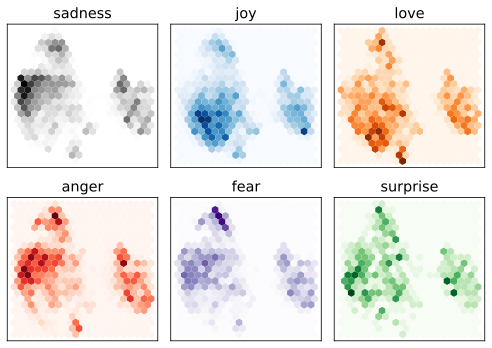

In [133]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
print(axes)
axes = axes.flatten() # flatten 2D numpy array to 1D
print(axes)
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
print(emotions["train"].features["label"])
print(labels)

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [134]:
# 위의 hidden state를 활용하여 Logistic Regression 모델 훈련
from sklearn.linear_model import LogisticRegression

# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [135]:
lr_clf.score(X_valid, y_valid)

0.633

#### 오차 행렬 (Confusion matrix)

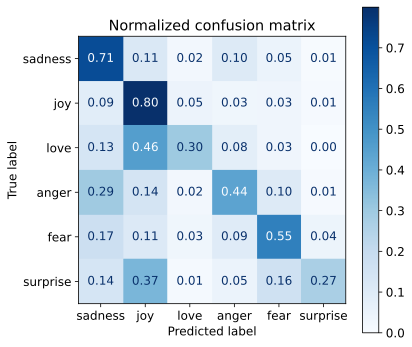

In [136]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

anger와 fear는 sadness로, love와 surprise는 joy로 많이 오인되고 있음

#### 미세 튜닝 
end-to-end 미세 튜닝

In [137]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

성공 지표 정의하기
- 성능을 모니터링 하기 위해 trainer에 사용할 compute_metrics() 정의

In [138]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [139]:
from huggingface_hub import notebook_login

notebook_login()

In [140]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size # iteration
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name, # output_dir: 훈련 과정에서 생성된 부산물이 저장됨
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [141]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/yejinkim/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/255M [00:00<?, ?B/s]

Download file runs/Mar26_02-18-12_845049c2c3a1/1679797115.0322678/events.out.tfevents.1679797115.845049c2c3a1.…

Download file runs/Mar26_02-18-12_845049c2c3a1/events.out.tfevents.1679797114.845049c2c3a1.551.0: 100%|#######…

Download file training_args.bin: 100%|##########| 3.56k/3.56k [00:00<?, ?B/s]

Clean file runs/Mar26_02-18-12_845049c2c3a1/1679797115.0322678/events.out.tfevents.1679797115.845049c2c3a1.551…

Clean file runs/Mar26_02-18-12_845049c2c3a1/events.out.tfevents.1679797114.845049c2c3a1.551.0:  20%|#9        …

Clean file training_args.bin:  28%|##8       | 1.00k/3.56k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.838100,0.316498,0.907500,0.904028
2,0.252400,0.218262,0.928500,0.928544


#### 오차 행렬 (Confusion matrix)

In [142]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [143]:
preds_output.metrics

{'test_loss': 0.21826159954071045,
 'test_accuracy': 0.9285,
 'test_f1': 0.9285439912301902,
 'test_runtime': 3.9242,
 'test_samples_per_second': 509.662,
 'test_steps_per_second': 8.155}

In [144]:
y_preds = np.argmax(preds_output.predictions, axis=1)

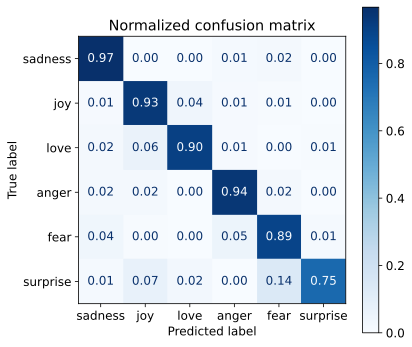

In [145]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 오류 분석

In [146]:
print(emotions_encoded["validation"]["label"])

tensor([0, 0, 2,  ..., 1, 1, 1])


In [147]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [148]:
# 데이터셋을 다시 파이토치 텐서로 변환
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값 계산
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [154]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
print(emotions_encoded["validation"])
df_test = emotions_encoded["validation"][:][cols] # validation의 모든 data들에 대해서 cols에 해당하는 값들을 확인하고자 함
print(df_test)
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss',
'predicted_label'],
    num_rows: 2000
})
                                                   text  label  \
0     im feeling quite sad and sorry for myself but ...      0
1     i feel like i am still looking at a blank canv...      0
2                        i feel like a faithful servant      2
3                     i am just feeling cranky and blue      3
4     i can have for a treat or if i am feeling festive      1
...                                                 ...    ...
1995  im having ssa examination tomorrow in the morn...      0
1996  i constantly worry about their fight against n...      1
1997  i feel its important to share this info for th...      1
1998  i truly feel that if you are passionate enough...      1
1999  i feel like i just wanna buy any cute make up ...      1

      predicted_label      loss
0                   0  0.025069
1                   0  0.027589
2                   2

In [155]:
print(df_test)

                                                   text    label  \
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv...  sadness
2                        i feel like a faithful servant     love
3                     i am just feeling cranky and blue    anger
4     i can have for a treat or if i am feeling festive      joy
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

     predicted_label      loss
0            sadness  0.025069
1            sadness  0.027589
2               love  0.431389
3              anger  0.052439
4                joy  0.014516
...              ...       ...

In [156]:
# loss가 큰 data set 찾기
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1195,i always think about are act the way i want to...,anger,joy,5.400648
1950,i as representative of everything thats wrong ...,surprise,sadness,5.384308
1963,i called myself pro life and voted for perry w...,joy,sadness,5.338665
882,i feel badly about reneging on my commitment t...,love,sadness,5.056340
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.009262
1274,i am going to several holiday parties and i ca...,joy,sadness,4.984080
1111,im lazy my characters fall into categories of ...,joy,fear,4.936882
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.907856
1509,i guess this is a memoir so it feels like that...,joy,fear,4.824113
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.586989


In [157]:
# loss가 작은 data set 찾기
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.013564
761,i feel like im smart now,joy,joy,0.013837
1101,im feeling good i increase,joy,joy,0.013841
199,i feel invigorated full of energy ready for th...,joy,joy,0.013888
1421,i feel undeservingly lucky to be surrounded by...,joy,joy,0.013967
1308,i feel there are very smart people that can co...,joy,joy,0.013990
1548,im not feeling very festive this year,joy,joy,0.014039
1873,i feel practically virtuous this month i have ...,joy,joy,0.014054
726,i feel too energetic and some days i just feel...,joy,joy,0.014065
517,i actually feel more energetic than usual rath...,joy,joy,0.014092


#### Model 저장 및 공유

In [158]:
trainer.push_to_hub(commit_message="Training completed!")

To https://huggingface.co/yejinkim/distilbert-base-uncased-finetuned-emotion
   0a9d2a6..b700186  main -> main

   0a9d2a6..b700186  main -> main

To https://huggingface.co/yejinkim/distilbert-base-uncased-finetuned-emotion
   b700186..b9cb2d8  main -> main

   b700186..b9cb2d8  main -> main



'https://huggingface.co/yejinkim/distilbert-base-uncased-finetuned-emotion/commit/b70018630a1b4794250d50b7bbe73b2eac614ea3'

미세 튜닝된 모델로 새로운 트윗에 대해 예측할 수 있다.

In [159]:
from transformers import pipeline

model_id = "yejinkim/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [160]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


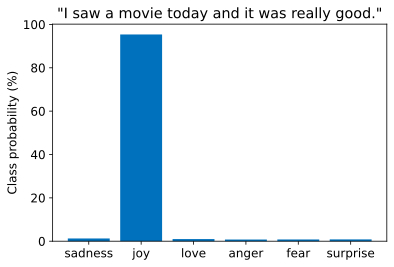

In [161]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


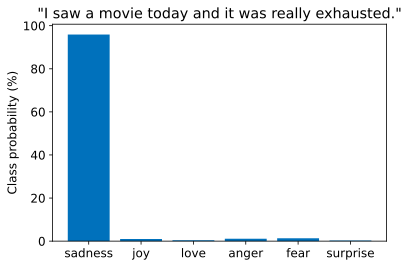

In [164]:
custom_tweet = "I saw a movie today and it was really exhausted."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


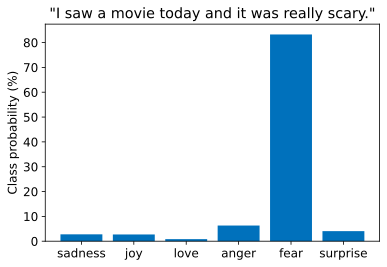

In [165]:
custom_tweet = "I saw a movie today and it was really scary."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


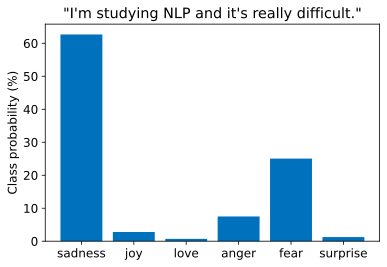

In [166]:
custom_tweet = "I'm studying NLP and it's really difficult."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()